# Small system sweep simulation

Here we demo how to run a sweep simulation, using a small system of 500 particles.  We will show plots of the energy landscape versus density and temperature, and begin to get a glimpse of the phase diagram of Lennard-Jonesium.  Of course, for such a small system of particles, most features of the phase diagram will be rather indistinct.

## Running the simulation

For running the actual simulation, the only dependency is the `lennardjones` package.  One could also use `numpy` as a source of random seeds, but `lennardjones` already exposes the C++ `std::random_device` seed generator, which is good enough for physics simulations.

In [1]:
import lennardjonesium as lj

### Setup

First we create an `lj.SweepConfiguration` object.  This is a `dataclass` which has mostly the same information as `lj.Configuration`, with some slight differences:

- In place of a temperature and density, we describe a *range* of temperatures and densities, using parameters similar to those used in `numpy.linspace()`.
- There is no `random_seed` parameter, since random seeds are assigned individually to each run (at particular values of density and temperature).
- There is a `templates` section where we can describe what the directory structure will look like.  Each simulation will run in its own directory and produce its own output files.

In [2]:
sc = lj.SweepConfiguration()

sc.system.temperature_start = 0.1
sc.system.temperature_stop = 2.0
sc.system.temperature_steps = 20

sc.system.density_start = 0.1
sc.system.density_stop = 1.4
sc.system.density_steps = 27

sc.system.particle_count = 500
sc.system.cutoff_distance = 2.0

sc.templates.directory = 'data/T_{temperature:f}/d_{density:f}'

sc.equilibration.tolerance = 0.05
sc.equilibration.sample_size = 200
sc.equilibration.adjustment_interval = 200
sc.equilibration.steady_state_time = 5000
sc.equilibration.timeout = 75000

sc.observation.tolerance = 0.10
sc.observation.sample_size = 200
sc.observation.observation_interval = 200
sc.observation.observation_count = 20

sc.write('sweep.ini')

### Using the `run_sweep()` function

Next, we load the `.ini` that was created, and start the simulation with `run_sweep()`.  This will automatically manage the creation of the whole directory tree of simulation results.  Each simulation will also get its own `run.ini` which can be (re)run with the `run()` function, if needed.

The individual simulations can be run concurrently by choosing the `thread_count` value.  All of the multithreading happens from within the C++ library, so it is not limited by the Python global interpreter lock.

In [3]:
result = lj.run_sweep(
    'sweep.ini',
    thread_count=12,
    random_seed=lj.SeedGenerator().get
)

================= Lennard-Jones Sweep Simulation ==================

Temperature: 20 points in the range [0.1, 2.0]
Density: 27 points in the range [0.1, 1.4]

Number of Particles: 500
Time Step: 0.005

Chunk index: 0, Chunk count: 1
Running 540 jobs over 12 threads

Begin simulation sweep...
Jobs queued: 0, Running: 0, Completed: 540                
End simulation sweep

Job status:
Completed: 538
Aborted during Equilibration: 0
Aborted during Observation: 2

6586600 time steps computed using 12 threads in 421.968 seconds
0.001 thread-seconds per step, or 0.769 milliseconds
Average framerate per thread: 1300.771 fps


The two lines

```
Aborted during Equilibration: 0
Aborted during Observation: 2
```

are important to note.  If a simulation was aborted during Equilibration, then it will not produce data and there will be a hole in our phase diagram.  It should be rerun, either with a different random seed or with different equilibration parameters, until it successfully equilibrates.

If a simulation was aborted during the Observation phase, this means it drifted too far from equilibrium for observations to remain valid.  We can use the `result` returned from `run_sweep()` to investigate what actually happened.  As long as we produced *some* observation data, then this is probably ok.  If we are unsatisfied with the number of measurements taken, then we should try re-running the aborted simulations with a new random seed.

In [4]:
# Check to see how many observations were obtained on the runs that aborted during observation
[len(entry.event_data.observations_recorded) for entry in result.observation_aborted]

[11, 18]

Again we measure how much data was produced from the simulation sweep.  In this case, it is too much to reasonably upload to GitHub, so I have limited which results files will appear in the repository.

In [5]:
import os
_ = os.system('du -sh data')

921M	data


## Analysing the results

First, let's import the necessary packages for analysis:

In [6]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib as mpl
from mpl_toolkits import mplot3d
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

import lennardjonesium as lj

Next we collect all of the sweep observations into a `pandas.DataFrame`.  The `lj.SweepConfiguration` object provides methods for iterating over all of the simulation directories in order to find the data files.

Given a sweep configuration `.ini` file, we can also re-read the `SweepResult` object that was originally returned by `run_sweep()`.  The constructor automatically visits all of the simulation directories and collects the same information to describe the overall success of the sweep.  This allows us to call `run_sweep()` once, and re-collect this data any time we'd like to do analysis.

In [7]:
sweep_config_file = pathlib.Path('sweep.ini')
sweep_config = lj.SweepConfiguration.from_file(sweep_config_file)
sweep_result = lj.orchestration.SweepResult(sweep_config_file)

Here we iterate over the results directories and collect the observation data.  We drop the `'TimeStep'` column, as we don't really care on which time step an observation was made.  Instead we will make plots vs density and temperature.

In [8]:
observations = pd.DataFrame()
for simulation_dir in sweep_config.simulation_dir_range():
    run_config = lj.Configuration.from_file(simulation_dir / sweep_config.templates.run_config_file)
    run_observations = pd.read_csv(
        simulation_dir / run_config.filepaths.observation_log).drop(columns=['TimeStep'])
    observations = pd.concat([observations, run_observations])

In [9]:
minima = observations.min()
maxima = observations.max()
ranges = maxima - minima

columns_of_interest = ('TotalEnergy', 'Pressure', 'DiffusionCoefficient')

exponents = {
    'TotalEnergy': 1.0,
    'Pressure': 0.45,
    'DiffusionCoefficient': 0.32
}

for column in columns_of_interest:
    scaled_column = 'Scaled' + column
    observations[scaled_column] = (observations[column] - minima[column]) / ranges[column]
    observations['Transformed' + column] = np.float_power(observations[scaled_column], exponents[column])

colormap = 'plasma'

### The energy landscape

As our first figure, let's plot total energy vs density and temperature.  In principle this energy landscape lets us deduce everything about the phase structure of the Lennard-Jones substance.

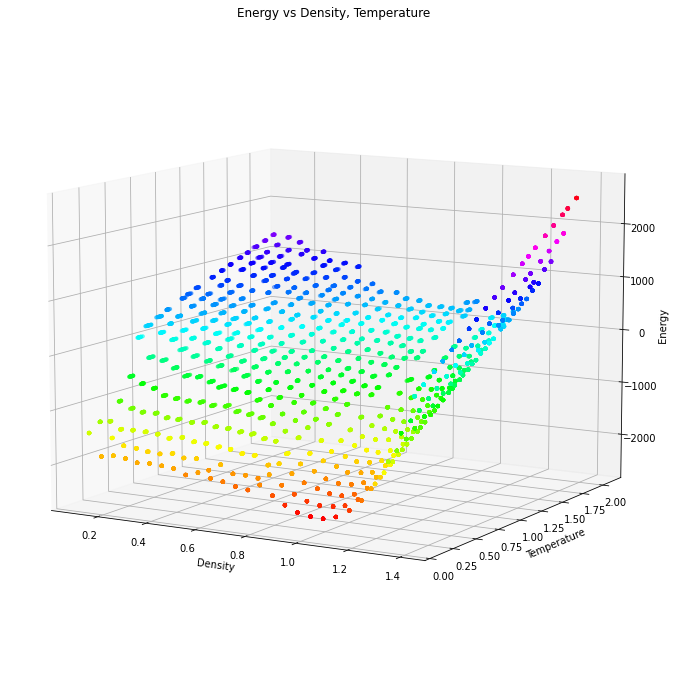

In [10]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')


ax.scatter3D(
    observations['Density'],
    observations['Temperature'],
    observations['TotalEnergy'],
    c=observations['TotalEnergy'],
    cmap='hsv',
    s=10
)

ax.set_xlabel('Density')
ax.set_ylabel('Temperature')
ax.set_zlabel('Energy')
ax.azim = -60
ax.elev = 10

plt.title("Energy vs Density, Temperature")
plt.show()

We see total energy as a function of density and temperature.  In the energy landscape, first order phase transitions correspond to discontinuous "jumps" in the energy across some line.  The height of the jump gives the latent heat associated with the phase transition.  Around density 0.8, we see something that looks a bit like a discontinuity, although at this level of detail it is quite hard to tell.

Second-order phase transitions correspond to abrupt changes in *slope*, which are even harder to observe in such a small, noisy simulation.  However, you might see a few candidate locations, especially in the low-density, low-temperature regime.

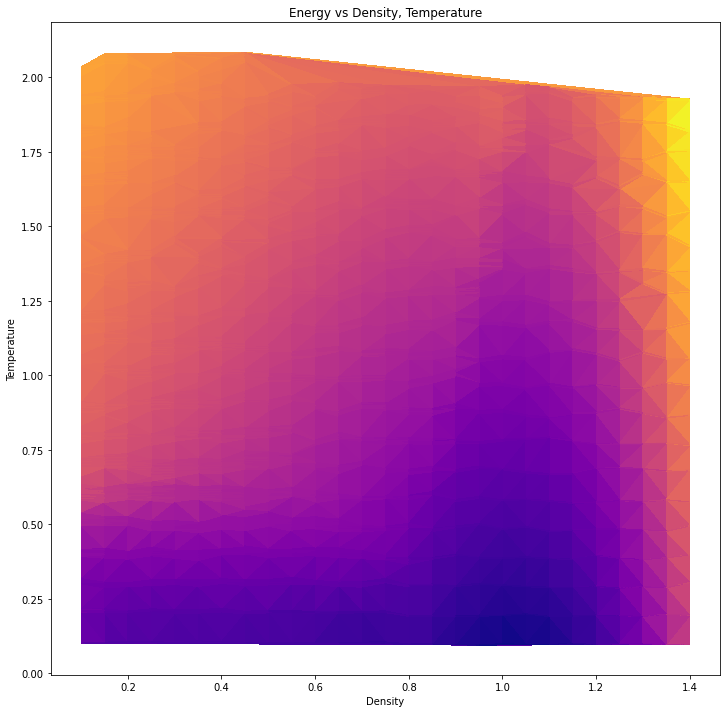

In [11]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

ax.tripcolor(
    observations['Density'],
    observations['Temperature'],
    observations['TransformedTotalEnergy'],
    cmap=colormap
)

ax.set_xlabel('Density')
ax.set_ylabel('Temperature')

plt.title("Energy vs Density, Temperature")
plt.show()

This is a top-down view of the energy landscape with color-coding for height.  It is a little easier to see some of the features here, although again, at this resolution, everything is fairly indistinct.

In reality, true discontinuous "jumps" in the internal energy of a system can only happen in the thermodynamic limit (i.e., an infinite number of particles), so we should not be surprised that 500 particles are not quite enough to see such jumps clearly.

### Pressure

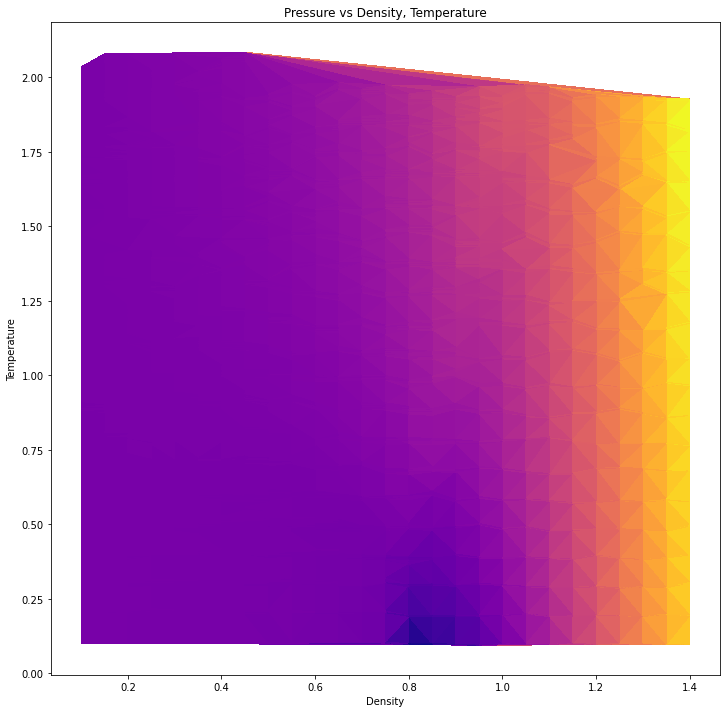

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

ax.tripcolor(
    observations['Density'],
    observations['Temperature'],
    observations['TransformedPressure'],
    cmap=colormap
)

ax.set_xlabel('Density')
ax.set_ylabel('Temperature')

plt.title("Pressure vs Density, Temperature")
plt.show()

Here we plot pressure, over the same range of density and temperature.  There is not much interesting to see, the pressure increases to the right with increasing density.  It does look like there is some sort of feature around density 1.0 and temperature 1.0 where there is some sort of inflection point.

### Diffusivity

The diffusivity is proportional to the slope of the mean square displacement over time, and it measures how quickly particles travel through a medium under Brownian motion.

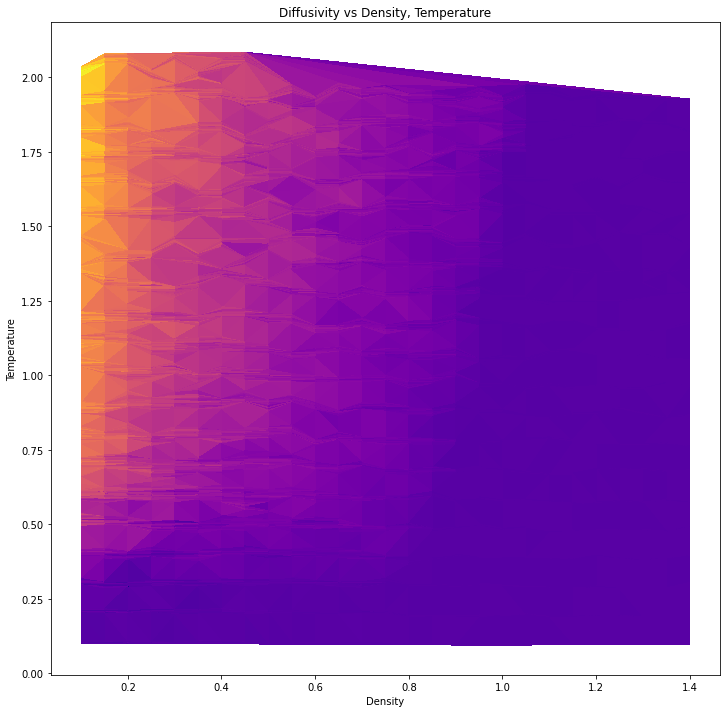

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

ax.tripcolor(
    observations['Density'],
    observations['Temperature'],
    observations['TransformedDiffusionCoefficient'],
    cmap=colormap
)

ax.set_xlabel('Density')
ax.set_ylabel('Temperature')

plt.title("Diffusivity vs Density, Temperature")
plt.show()

Here we see, as expected, the diffusivity increases with increasing temperature and decreasing density.  The plot is far too indistinct to tell if there are any features that align with the features we saw in the energy landscape.  In a way, this is disappointing, because we would like not only to find phase transitions, but to classify the phases on either side as solid or fluid, and diffusivity is the main measure of that.  We will see what turns up in higher-precision experiments with more particles.

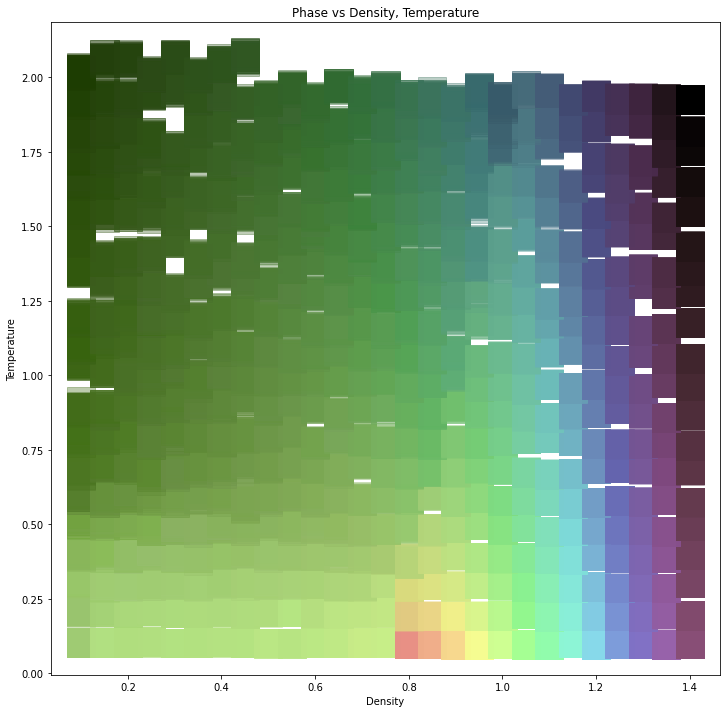

In [18]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

base_saturation = 0.15
rescale = 1 - base_saturation

hsv_colors = list(zip(
    observations['TransformedPressure'],
    base_saturation + rescale * observations['TransformedDiffusionCoefficient'],
    1 - observations['TransformedTotalEnergy'],
))

rgb_colors = [mpl.colors.hsv_to_rgb(c) for c in hsv_colors]

ax.scatter(
    observations['Density'],
    observations['Temperature'],
    s=800,
    c=rgb_colors,
    alpha=0.35,
    marker='s'
)

ax.set_xlabel('Density')
ax.set_ylabel('Temperature')

plt.title("Phase vs Density, Temperature")
plt.show()